# Preparation

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Core Libraries
import os
import copy
import numpy as np
import pandas as pd
from math import floor
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch and TorchVision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
# Transformers
from transformers import ViTModel

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    np.random.seed(seed)
    random.seed(seed)

    # Ensures deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(11)

# Data Paths
DATA_DIR = "/content/drive/Shareddrives/github/cookie_anomaly_detection/data/IndustryBiscuit/DS"
trainPath = os.path.join(DATA_DIR, 'train')
testPath = os.path.join(DATA_DIR, 'test')
valPath = os.path.join(DATA_DIR, 'valid')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ViT-VAE Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import ViTModel

class ViTVAE(nn.Module):

    def __init__(self, img_size, nb_channels, latent_img_size, z_dim, rec_loss="xent", beta=1, delta=1):
        super(ViTVAE, self).__init__()

        self.img_size = img_size
        self.nb_channels = nb_channels
        self.latent_img_size = latent_img_size
        self.z_dim = z_dim
        self.beta = beta
        self.rec_loss = rec_loss
        self.delta = delta
        self.nb_conv = 3
        self.max_depth_conv = 384

        # Load pretrained ViT
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')

        # Optional: freeze ViT if needed
        # for param in self.vit.parameters():
        #     param.requires_grad = False

        self.out_en = nn.Sequential(
            nn.Conv2d(3, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )

        # Decoder setup
        self.decoder_layers = []
        for i in reversed(range(1, 5)):
            depth_in = 3 * 2 ** (2 + i + 1)
            depth_out = 3 * 2 ** (2 + i)
            if i == 1:
                depth_out = self.nb_channels
                self.decoder_layers.append(
                    nn.ConvTranspose2d(depth_in, depth_out, 4, 2, 1)
                )
            else:
                self.decoder_layers.append(nn.Sequential(
                    nn.ConvTranspose2d(depth_in, depth_out, 4, 2, 1),
                    nn.BatchNorm2d(depth_out),
                    nn.ReLU()
                ))

        self.conv_decoder = nn.Sequential(*self.decoder_layers)

    def encoder(self, x):
        x = self.vit(x)[0][:, 1:, :]  # skip [CLS] token
        x = x.permute(0, 2, 1)        # (B, hidden_dim, patch_count)
        x = x.reshape(x.shape[0], x.shape[1], 14, 14)
        return x[:, :self.z_dim], x[:, self.z_dim:]

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps * std + mu
        else:
            return mu

    def decoder(self, z):
        x = self.conv_decoder(z)
        x = torch.sigmoid(x)
        return x

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        self.mu = mu
        self.logvar = logvar
        return self.decoder(z), (mu, logvar)

    def kld(self):
        return 0.5 * torch.sum(
            1 + self.logvar - self.mu.pow(2) - self.logvar.exp(), dim=(1)
        )

    def loss_function(self, recon_x, x):
        rec_term = F.binary_cross_entropy(recon_x, x, reduction='sum') / x.size(0)
        kld = -torch.mean(self.kld())
        loss = rec_term + self.beta * kld
        return loss, {
            'loss': loss,
            'rec_term': rec_term,
            '-beta*kld': self.beta * kld
        }

    def step(self, input_mb):
        recon_mb, _ = self.forward(input_mb)
        loss, loss_dict = self.loss_function(recon_mb, input_mb)
        return loss, recon_mb, loss_dict


# Dataset

In [3]:
batch_size=50

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = datasets.ImageFolder(root=trainPath, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = datasets.ImageFolder(root=valPath, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

test_dataset = datasets.ImageFolder(root=testPath, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialization

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_vitvae = ViTVAE(
    img_size=224,
    nb_channels=3,
    latent_img_size=14,
    z_dim=384,         # must be ≤ ViT output channels (usually 768)
    rec_loss="xent",
    beta=1.0
).to(device)
optimizer = optim.Adam(model_vitvae.parameters(), lr=1e-4)

cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training Loop

In [5]:
# Track losses per epoch
train_total_losses = []
train_rec_losses = []
train_kld_losses = []

In [6]:
num_epochs = 100
model_vitvae.train()

for epoch in range(num_epochs):
    total_epoch_loss = 0
    total_epoch_rec = 0
    total_epoch_kld = 0

    for inputs, _ in train_loader:
        inputs = inputs.to(device)

        optimizer.zero_grad()
        loss, _, loss_dict = model_vitvae.step(inputs)
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()
        total_epoch_rec += loss_dict["rec_term"].item()
        total_epoch_kld += -loss_dict["-beta*kld"].item() / model_vitvae.beta  # Convert back to raw KLD



    # Average losses for this epoch
    avg_loss = total_epoch_loss / len(train_loader)
    avg_rec = total_epoch_rec / len(train_loader)

    avg_kld = total_epoch_kld / len(train_loader)
    # print(avg_kld)
    # print(total_epoch_kld)


    train_total_losses.append(avg_loss)
    train_rec_losses.append(avg_rec)
    train_kld_losses.append(avg_kld)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Total Loss: {avg_loss:.4f} | Recon: {avg_rec:.4f} | KLD: {avg_kld:.4f}")

Epoch [1/100] | Total Loss: 98738.4012 | Recon: 98481.7902 | KLD: -256.6114
Epoch [2/100] | Total Loss: 83857.4043 | Recon: 83630.9766 | KLD: -226.4279
Epoch [3/100] | Total Loss: 79941.1289 | Recon: 79754.3004 | KLD: -186.8285
Epoch [4/100] | Total Loss: 78059.4559 | Recon: 77894.3703 | KLD: -165.0858
Epoch [5/100] | Total Loss: 76958.4434 | Recon: 76806.1270 | KLD: -152.3167
Epoch [6/100] | Total Loss: 76228.8027 | Recon: 76089.1730 | KLD: -139.6296
Epoch [7/100] | Total Loss: 75729.3844 | Recon: 75596.6613 | KLD: -132.7228
Epoch [8/100] | Total Loss: 75361.1684 | Recon: 75234.8324 | KLD: -126.3360
Epoch [9/100] | Total Loss: 75098.4543 | Recon: 74976.4898 | KLD: -121.9651
Epoch [10/100] | Total Loss: 74892.4613 | Recon: 74774.7977 | KLD: -117.6638
Epoch [11/100] | Total Loss: 74731.6086 | Recon: 74616.4602 | KLD: -115.1486
Epoch [12/100] | Total Loss: 74598.5559 | Recon: 74486.4801 | KLD: -112.0761
Epoch [13/100] | Total Loss: 74500.5531 | Recon: 74390.7145 | KLD: -109.8393
Epoch [1

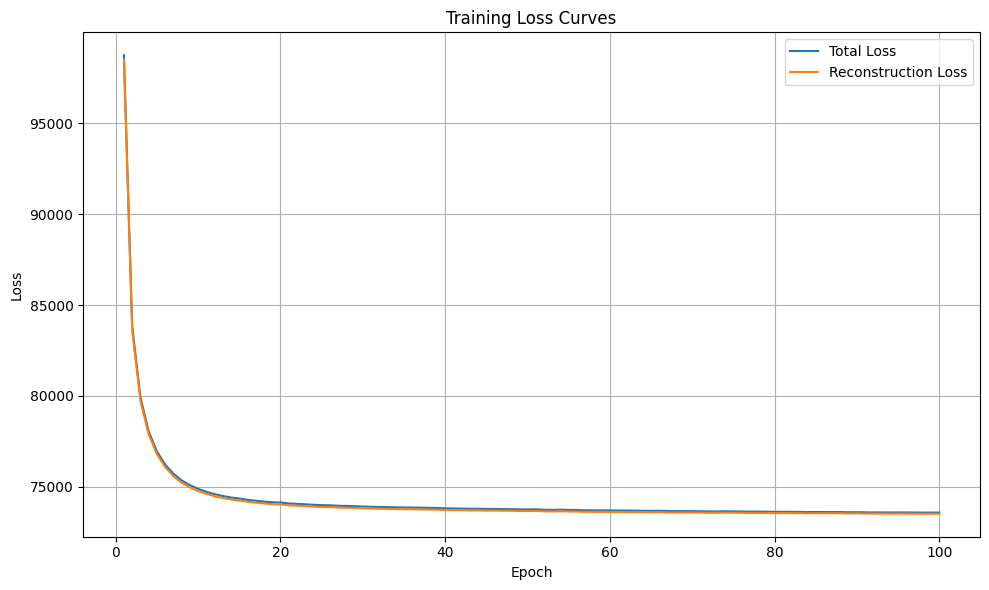

In [7]:
import matplotlib.pyplot as plt

# Plot training loss curves
epochs = range(1, len(train_total_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_total_losses, label='Total Loss')
plt.plot(epochs, train_rec_losses, label='Reconstruction Loss')
# plt.plot(epochs, train_kld_losses, label='KL Divergence')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Find anomaly threshold using validation set

In [32]:
import numpy as np
import torch
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_recall_curve,
    precision_score, recall_score
)

model_vitvae.eval()
recon_errors = []
gt_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        recon_x, _ = model_vitvae(inputs)

        # Compute per-image BCE reconstruction error
        bce = F.binary_cross_entropy(recon_x, inputs, reduction='none')
        error = bce.reshape(bce.size(0), -1).sum(dim=1)   # shape: [batch_size]

        recon_errors.extend(error.cpu().numpy())
        gt_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays
recon_errors = np.array(recon_errors)
gt_labels = np.array(gt_labels)
gt_labels = 1 - gt_labels

# Precision-Recall and F1
prec, recall, thresholds = precision_recall_curve(gt_labels, recon_errors)
f1_scores = 2 * (prec * recall) / (prec + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Final binary predictions
pred_labels = (recon_errors >= best_threshold).astype(int)

# Metrics
precision = precision_score(gt_labels, pred_labels)
recall = recall_score(gt_labels, pred_labels)
auc = roc_auc_score(gt_labels, recon_errors)

# Print results
print(f"Best threshold: {best_threshold:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {best_f1:.4f}")
print(f"AUC:       {auc:.4f}")


Best threshold: 70077.5703
Precision: 0.5000
Recall:    1.0000
F1 Score:  0.6667
AUC:       0.5058


# Test set evaluation

In [33]:
import numpy as np
import torch
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_recall_curve,
    precision_score, recall_score
)

model_vitvae.eval()
test_recon_errors = []
test_gt_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        recon_x, _ = model_vitvae(inputs)

        # Compute per-image BCE reconstruction error
        bce = F.binary_cross_entropy(recon_x, inputs, reduction='none')
        error = bce.reshape(bce.size(0), -1).sum(dim=1)  # shape: [batch_size]

        test_recon_errors.extend(error.cpu().numpy())
        test_gt_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays
test_recon_errors = np.array(test_recon_errors)
test_gt_labels = np.array(test_gt_labels)
test_gt_labels = 1 - test_gt_labels  # Invert labels for testing
# Use the best threshold from validation (assumed stored in `best_threshold`)
test_pred_labels = (test_recon_errors >= best_threshold).astype(int)

# Compute test metrics
test_precision = precision_score(test_gt_labels, test_pred_labels)
test_recall = recall_score(test_gt_labels, test_pred_labels)
test_f1 = f1_score(test_gt_labels, test_pred_labels)
test_auc = roc_auc_score(test_gt_labels, test_recon_errors)

# Print test results
print(f"[TEST] Precision: {test_precision:.4f}")
print(f"[TEST] Recall:    {test_recall:.4f}")
print(f"[TEST] F1 Score:  {test_f1:.4f}")
print(f"[TEST] AUC:       {test_auc:.4f}")


[TEST] Precision: 0.4898
[TEST] Recall:    0.9600
[TEST] F1 Score:  0.6486
[TEST] AUC:       0.6091


# Save model

In [41]:
torch.save(model_vitvae.state_dict(), "/content/drive/Shareddrives/github/cookie_anomaly_detection/vitvae_state_dict.pth")


# Reconstruction Visualization

[  0  14  28  42  56  71  85  99 113 127 142 156 170 184 199]


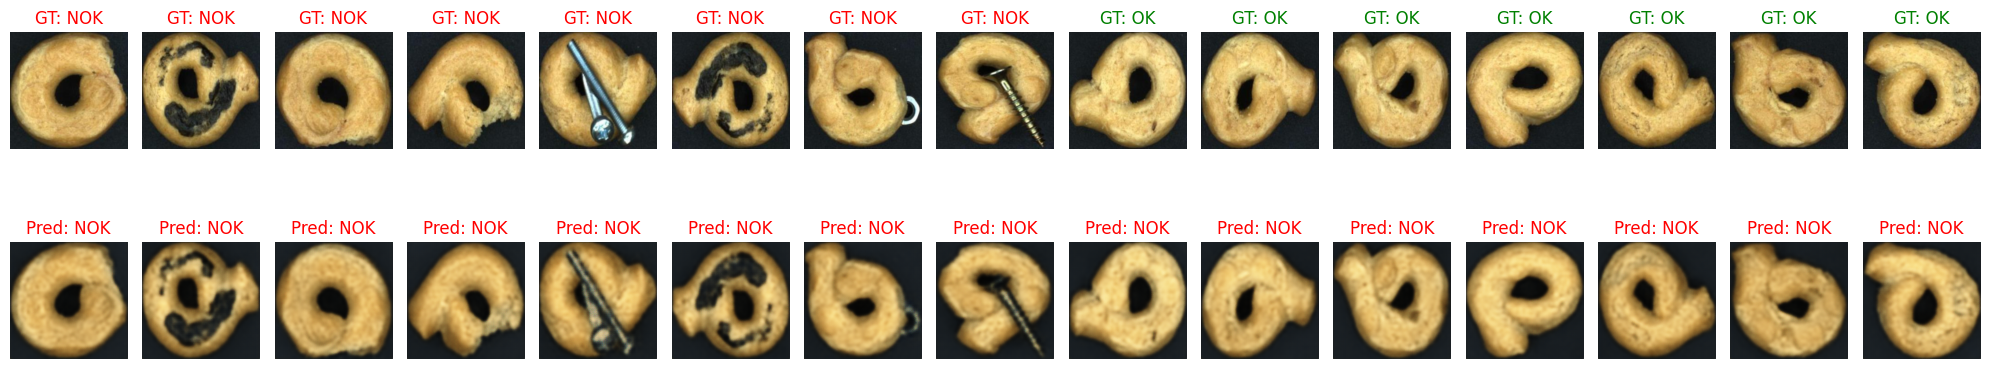

In [40]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

model_vitvae.eval()
all_imgs = []
all_labels = []

# --- Step 1: Collect enough test images ---
with torch.no_grad():
    for inputs, labels in test_loader:
        all_imgs.append(inputs)
        all_labels.append(labels)
        if len(torch.cat(all_imgs)) > 200:
            break

all_imgs = torch.cat(all_imgs)
all_labels = torch.cat(all_labels)
num_total = all_imgs.size(0)

# --- Step 2: Sample 10 evenly spaced images and labels ---
num_samples = 15
indices = np.linspace(0, num_total - 1, num_samples, dtype=int)
print(indices)
sampled_imgs = all_imgs[indices].to(device)
sampled_labels = all_labels[indices].cpu().numpy()

# --- Step 3: Run reconstructions and compute errors ---
with torch.no_grad():
    recon_imgs, _ = model_vitvae(sampled_imgs)
    recon_imgs = recon_imgs.clamp(0, 1)

    bce = F.binary_cross_entropy(recon_imgs, sampled_imgs, reduction='none')
    errors = bce.reshape(bce.size(0), -1).sum(dim=1).cpu().numpy()

# --- Step 4: Predict labels using threshold from validation ---
pred_labels = (errors >= best_threshold).astype(int)

# --- Step 5: Plot results ---
def imshow_tensor(tensor_img):
    img = tensor_img.detach().cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off')

plt.figure(figsize=(20, 5))

for i in range(num_samples):
    gt = sampled_labels[i]
    gt = 1-gt
    pred = pred_labels[i]

    # Top: Original with ground truth
    plt.subplot(2, num_samples, i + 1)
    imshow_tensor(sampled_imgs[i])
    title = f"GT: {'NOK' if gt == 1 else 'OK'}"
    plt.title(title, color='red' if gt == 1 else 'green')

    # Bottom: Reconstruction with prediction
    plt.subplot(2, num_samples, num_samples + i + 1)
    imshow_tensor(recon_imgs[i])
    title = f"Pred: {'NOK' if pred == 1 else 'OK'}"
    plt.title(title, color='red' if pred == 1 else 'green')

plt.tight_layout()
plt.show()

# Latent Space Visualization

In [49]:
def get_latents_and_labels(dataloader):
    model_vitvae.eval()
    all_latents = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            mu, logvar = model_vitvae.encoder(inputs)
            z = model_vitvae.reparameterize(mu, logvar)
            all_latents.append(z.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_latents = np.concatenate(all_latents, axis=0)         # [N, z_dim, H, W]
    all_latents_flat = all_latents.reshape(all_latents.shape[0], -1)  # [N, D]
    all_labels = np.array(all_labels)
    return all_latents_flat, all_labels

# Get latent vectors and labels for both sets
train_latents, train_labels = get_latents_and_labels(train_loader)
train_labels = 1-train_labels
val_latents, val_labels = get_latents_and_labels(valid_loader)

# Combine both sets
all_latents = np.concatenate([train_latents, val_latents], axis=0)
all_labels = np.concatenate([train_labels, val_labels], axis=0)


In [50]:
all_latents.shape

(1200, 75264)

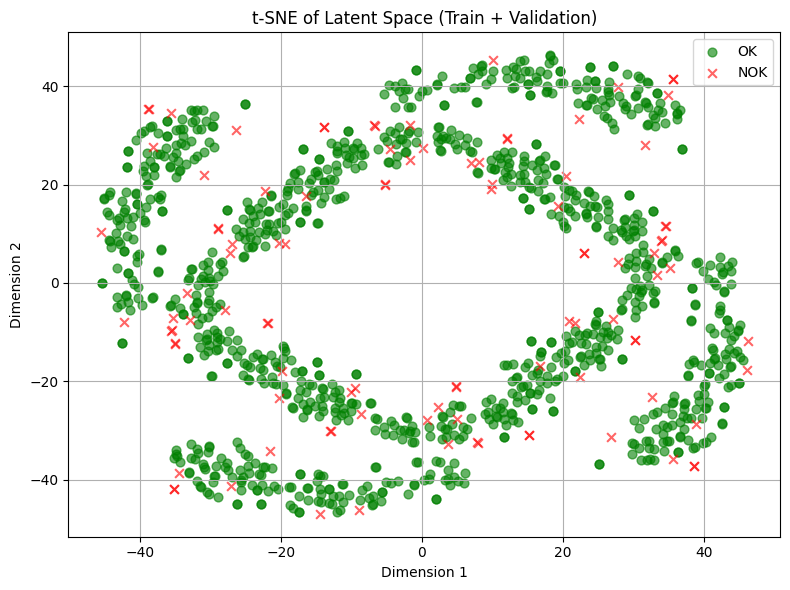

In [51]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Run t-SNE on combined data
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latents_2d = tsne.fit_transform(all_latents)

# Create mask for OK/NOK
ok_mask = all_labels == 1
nok_mask = all_labels == 0

plt.figure(figsize=(8, 6))
plt.scatter(latents_2d[ok_mask, 0], latents_2d[ok_mask, 1],
            label="OK", alpha=0.6, s=40, color="green")
plt.scatter(latents_2d[nok_mask, 0], latents_2d[nok_mask, 1],
            label="NOK", alpha=0.6, s=40, color="red", marker="x")

plt.title("t-SNE of Latent Space (Train + Validation)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()